# Modelling part 1

## 1. Import libraries and explore data

In [586]:
#import libraries
import pandas as pd
import numpy as np
import collections
import re
import sys
import time
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import wordninja
from itertools import islice
import pickle

In [587]:
df = pd.DataFrame(pd.read_pickle('df_music'))

In [588]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              5100 non-null   int64  
 1   Song              5100 non-null   object 
 2   Artist            5100 non-null   object 
 3   Year              5100 non-null   int64  
 4   Lyrics            4913 non-null   object 
 5   Source            4913 non-null   float64
 6   Artists clean     5100 non-null   object 
 7   artist_song1      5100 non-null   object 
 8   songs_clean       5100 non-null   object 
 9   artist_song2      5100 non-null   object 
 10  danceability      5083 non-null   object 
 11  energy            5083 non-null   object 
 12  key               5083 non-null   object 
 13  loudness          5083 non-null   object 
 14  mode              5083 non-null   object 
 15  speechiness       5083 non-null   object 
 16  acousticness      5083 non-null   object 


In [589]:
df.shape

(5100, 29)

## 2. Drop songs without or with missing lyrics

In [590]:
# drop rows with missing values

df = df[df.Lyrics != " NA "]
df.dropna( how='any', subset=['Lyrics'], inplace=True)
#reset index
df.reset_index(inplace=True, drop=True)
print("The number of remaining songs is: ", df.shape[0])

The number of remaining songs is:  4897


In [591]:
#remove songs that are instrumental

df=df[df['Lyrics']!='instrumental'] 
df=df[df['Lyrics']!=' instrumental'] 
df=df[df['Lyrics']!=' instrumental '] 
df=df[df['Lyrics']!='instrumental ']
print("The number of remaining songs is: ", df.shape[0])

The number of remaining songs is:  4878


## 3. Clean lyrics and tokenize

In [592]:
# clean lyrics - remove punctuation

In [593]:
lyrics=[]

for lyric in df.Lyrics: 
    lyric_string=re.sub('[^A-Za-z]+', ' ', lyric)
    lyrics_string = re.sub('/\s\s+/g', ' ', lyric)
    lyrics.append(lyric_string.lstrip())


In [594]:
# apply wordninja as some lyrics have words crunched together in one string
lyrics_clean=[]
for lyric in lyrics :
    string=wordninja.split(lyric)
    title=""
    for s in string:
        title+=s+" " 
    lyrics_clean.append(title.strip())

In [595]:
#add to df
df['lyrics_clean']=lyrics_clean

In [596]:
#apply lemmatizer and tokenizer
# apply word tokenizer, delete stopwords, and apply lemmatizer
tokens=[]
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for row in lyrics_clean:
    row_tokens=word_tokenize(row)
    filtered_sent = [w for w in row_tokens if not w.lower() in stop_words]
    stemmed = [lemmatizer.lemmatize(word) for word in filtered_sent]
    tokens.append(stemmed)
df['tokens']=tokens

## 4. Make more features

In [597]:
# more features

#get no of unique words per song lyric
count_words=[]
for row in df.tokens:
    unique = set(row) 
    count_words.append(len(unique))
#and add to df
df["unique_words"]=count_words

#keep only rows where no of words !=0
df=df[df['unique_words']!=0]
df.shape[0]

4831

In [598]:
##get total no of words per song lyric
total_words=[]
for row in df.tokens:
    length = len(row) 
    total_words.append(length)
df['total_words']=total_words

In [599]:
## get avg word length
word_length=[]
for row in df.tokens:
    length_row = len(row)
    length_word=sum([len(word) for word in row])/length_row
    word_length.append(length_word)
df['word_length']=word_length

In [600]:
## rhyming words

#!pip install phyme

In [601]:
from Phyme import Phyme

ph = Phyme()

In [602]:
# find number of words per song that are perfect rhymes 
#perfect rhymes. DOG -> COG
def get_rhymes(word):
    list_dict=[value for key,value in ph.get_perfect_rhymes(word).items()]
    all_rhymes=[]
    for row in list_dict:
        for word in row:
            all_rhymes.append(word)
    all_rhymes=list(set(all_rhymes))
    return all_rhymes
    
def count_rhymes(text):
    rhyme_count=0
    for word in list(set(text)):
        try:
            all_rhymes=get_rhymes(word) # get list of all words that rhyme
            for x in all_rhymes: # for each of these words, check if it is contained in the lyrics
                if x in text:
                    rhyme_count+=1
                else: 
                    pass
        except:
            pass
    return rhyme_count          
        

In [603]:
#apply functions to lists of lyric tokens
count_rhyming_words=[]
for lyric in df.tokens:
    count=count_rhymes(lyric)
    count_rhyming_words.append(count)

In [604]:
df['count_rhyming_words']=count_rhyming_words

In [605]:
#apply tfidf vectorizer after count vecotizer with n_gram_range==5

In [606]:
#count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

def dummy(tokens):
    return tokens

cv = CountVectorizer(
        tokenizer=dummy,
        preprocessor=dummy,
        ngram_range=(1, 3)
    )  
tokens=df.tokens
x = cv.fit_transform(tokens)
words = cv.get_feature_names()
len(words)


756386

In [607]:
#tfidf vectorizer 
vectorizer = TfidfVectorizer(tokenizer=dummy,
        preprocessor=dummy,
        ngram_range=(1, 3), dtype="uint8")

X_tfidf = vectorizer.fit(tokens.values) 

idf_scores = X_tfidf.idf_


In [608]:
X_tfidf.get_feature_names()[:10]

['aaa',
 'aaa aaa',
 'aaa aaa ah',
 'aaa aaa dont',
 'aaa ah',
 'aaa ah aaa',
 'aaa dont',
 'aaa dont leave',
 'aaa dont try',
 'aaa huh']

In [609]:
#filter out ngrams that occur in too few or too many songs
#DO THE CUTOFFS MAKE SENSE??
filtered_indices = np.argwhere(((idf_scores> 8) & (idf_scores<11.55) ))
filtered_indices = [idx[0] for idx in filtered_indices]

#list of vocabulary from the vectorizer
vocabulary = X_tfidf.get_feature_names()

#preparing a list with filtered vocabulary
filtered_voc = [vocabulary[i] for i in filtered_indices]

In [610]:
filtered_voc

['aaa aaa',
 'aaa aaa ah',
 'aaa aaa dont',
 'aaa ah',
 'aaa ah aaa',
 'aaa dont',
 'aaa dont leave',
 'aaa dont try',
 'aaa huh',
 'aaa huh hah',
 'aaa ill',
 'aaa ill never',
 'aaa look',
 'aaa look around',
 'aaa oh',
 'aaa oh dont',
 'aaa yea',
 'aaa yea yea',
 'aaaa aaaa',
 'aaaa aaaa aaaa',
 'aaaa get',
 'aaaa get bang',
 'aaaa h',
 'aaaa h ah',
 'aaaa hey',
 'aaaa hey yo',
 'aaaa oh',
 'aaaa oh oh',
 'aaaa oho',
 'aaaa oho hh',
 'aaaa ooo',
 'aaaa ooo ow',
 'aaaa sean',
 'aaaa sean paul',
 'aaaa take',
 'aaaa take meanwhile',
 'aaaa woo',
 'aaaa woo ooo',
 'aaaa yea',
 'aaaa yea town',
 'aaaaaa aaaaaa',
 'aaaaaa aaaaaa aaaaaa',
 'aaaaaa aaaaaa h',
 'aaaaaa ah',
 'aaaaaa ah want',
 'aaaaaa baa',
 'aaaaaa boy',
 'aaaaaa boy worth',
 'aaaaaa h',
 'aaaaaa h dont',
 'aaaaaa h meet',
 'aaaaaa mack',
 'aaaaaa mack dope',
 'aaaaaa oho',
 'aaaaaa oho hoh',
 'aaaaaa time',
 'aaaaaa time new',
 'aaliyah brandy',
 'aaliyah brandy tell',
 'aaliyah g',
 'aaliyah g u',
 'aaliyah see',
 'aaliya

In [611]:
#keep only filtered indices
X_tfidf=vectorizer.fit_transform(tokens.values)[:,filtered_indices]
type(X_tfidf)
print(X_tfidf.shape)

(4831, 726889)


In [612]:
len(filtered_indices)

726889

## 5. Join music features, lyrics features and tfidf features

In [613]:
music_features=['danceability', 'key', 'loudness','energy','acousticness', 'speechiness', 'mode', 'instrumentalness', 'liveness','valence', 'tempo']
X_music=df[music_features]
X_music=X_music.fillna(X_music.mean())


In [614]:
#list of lyrics features

add_features=['word_length', 'unique_words', 'total_words','count_rhyming_words']

In [615]:
#join lyrics data with musical features
#stack sparse matrices
from scipy.sparse import hstack
import scipy.sparse

X_m=scipy.sparse.csr_matrix(X_music.values)
print(X_m.shape)

X_l=scipy.sparse.csr_matrix(df[add_features].values)
print(X_l.shape)





(4831, 11)
(4831, 4)


In [616]:
X.shape[1]

726904

In [617]:
#array of column names
columns=filtered_voc+music_features+add_features
col_names = np.array(columns)
col_names

array(['aaa aaa', 'aaa aaa ah', 'aaa aaa dont', ..., 'unique_words',
       'total_words', 'count_rhyming_words'], dtype='<U50')

## 5. Build models

### simple

In [618]:
#save labels: ranking<50=1, 0 otherwise
y=pd.cut(df.Rank,bins=[0,50,100],labels=[1,0])
df['y']=y
df[['y','Rank']].groupby('y').mean()
len(y)
df.Rank.groupby(y).mean()

Rank
1    25.435178
0    75.410959
Name: Rank, dtype: float64

In [619]:
#make test_train_split
from sklearn.model_selection import train_test_split


In [620]:
# Initiate Logistic Classifier

In [621]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def simple_logistic_classify(X_train, y_train, X_test, y_test, _C=1.0):
    model = LogisticRegression(C=_C,  max_iter=10000).fit(X_train, y_train)
    score_test=roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    #get most important features
    col_index=range(X_train.shape[1])
    importance =dict(zip(col_index, list(model.coef_[0])))
    sort={k: v for k, v in sorted(importance.items(), reverse=True, key=lambda item: item[1])}
    n_items=list(islice(sort.items(), 5))
    coeffs=[round(i[1],5) for i in n_items]
    indices=[i[0] for i in n_items]
    item_names=col_names[indices]
    item_dict=dict(zip(item_names,coeffs))
    print('ROC-AUC Score Test', score_test)
    print('5 most important items', item_dict)
    return score_test, item_dict

In [622]:
# initiate random forest classifier
from sklearn.ensemble import RandomForestRegressor

def simple_rf_classify(X_train, y_train, X_test, y_test):
    model =  RandomForestRegressor(random_state=0, n_estimators=100).fit(X_train, y_train)
    score_test=roc_auc_score(y_test, model.predict(X_test))
    #get most important features
    importance=model.feature_importances_
    feat_dict=dict(zip(col_names,importance))
    sort={k: v for k, v in sorted(feat_dict.items(), reverse=True, key=lambda item: item[1])}
    n_items=list(islice(sort.items(), 5))
    coeffs=[round(i[1],5) for i in n_items]
    indices=[i[0] for i in n_items]
    #item_names=col_names[indices]
    #item_dict=dict(zip(item_names,coeffs))
    print('ROC-AUC Score Test', score_test)
    print('5 most important items', n_items)
    return n_items, score_test, sort, feat_dict

In [623]:
#simple logistic model of word vectors

In [624]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y, test_size=0.33, random_state=42)

In [625]:
import warnings
warnings.filterwarnings('ignore')

In [626]:
logistic=simple_logistic_classify(X_train, y_train, X_test, y_test, _C=1.0)

ROC-AUC Score Test 0.49729427528095194
5 most important items {'locomotion': 0.37232, 'would anything love': 0.3463, 'julie': 0.32331, 'pussycat': 0.30176, 'let dance let': 0.28939}


In [627]:
randomforest=simple_rf_classify(X_train, y_train, X_test, y_test)

ROC-AUC Score Test 0.4858651242227234
5 most important items [('live know', 0.0007444733395615924), ('like long lost', 0.000670177644070157), ('gone gone away', 0.0006565080397986004), ('justified', 0.0006102313282901324), ('yes doi', 0.0006101157569509192)]


In [628]:
best_50=list(randomforest[2].items())[:50]
best_50_features=[i[0] for i in best_50]
best_50_scores=[i[1] for i in best_50]

<BarContainer object of 50 artists>

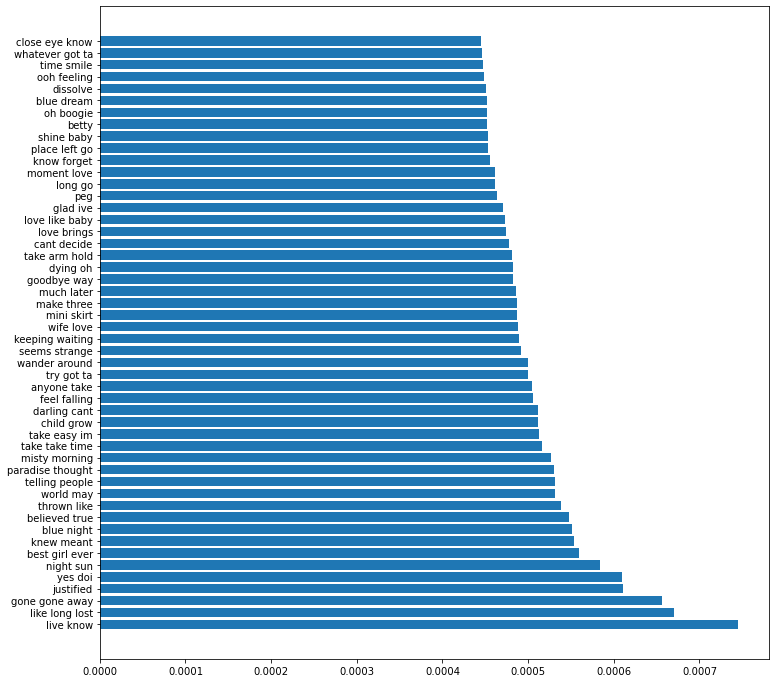

In [629]:
plt.figure(figsize=(12,12))
plt.barh(best_50_features, best_50_scores)

In [630]:
#Select top 1000 features
top_1000=list(randomforest[2].items())[:1000]
top_1000_feat=[i[0] for i in top_1000]
#select top200 feat from X_tfidf
#get indices of top1000 features from filtered_voc
top_1000_indices = [i for i, value in enumerate(filtered_voc) if value in top_1000_feat]
X_1000=X_tfidf[:,top_1000_indices]
X_1000.shape

(4831, 1000)

In [701]:
#combine with additional features
X_text=hstack((X_1000, X_l))
print(X_text.shape)
X_all=hstack((X_1000, X_m))
print(X_all.shape)

(4831, 1004)
(4831, 1011)


### Hyperparameter tuning

#### Logistic regression

In [702]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

In [703]:
#define parameter grid for logistic cv

C = [0.00001,0.0001, 0.001, 0.01, 0.1,1,10,100,1000, 10000]
penalty = ['l2']

parameters = dict(C=C, penalty=penalty)

In [704]:
def logistic_cv(X_train, X_test, y_train, y_test):
    logistic=LogisticRegression(max_iter=500)
    gsl=GridSearchCV(logistic, parameters, cv=3, n_jobs=-1, scoring="roc_auc")
    gsl.fit(X_train, y_train)
    return gsl

In [705]:
#fit tuned model
def fit_tuned_lr_model(model):    
    logisticCV=LogisticRegression(C=model.best_params_['C'], penalty=model.best_params_['penalty'], max_iter=500)
    logisticCV.fit(X_train, y_train)

    #return predicted probabilities
    lr_probs = logisticCV.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    roc_auc=roc_auc_score(y_test, lr_probs)
    print("tuned hyperparameters :(best parameters) ", model.best_params_)
    print("ROC AUC :", model.best_score_)
    print("Fitted tuned logit  model ", roc_auc)
    return logisticCV,roc_auc, fpr, tpr

In [706]:
#Logistic Classifier on tfidf features only 
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)

In [707]:
# save the tuned model to disk
filename = 'tuned_logistic_only_text_1000.sav'
pickle.dump(lr, open(filename, 'wb'))

In [708]:
#fit tuned model
lr_fit_tfidf=fit_tuned_lr_model(lr)


tuned hyperparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
ROC AUC : 0.5077370032517401
Fitted tuned logit  model  0.4969828928372602


In [709]:
# save the tuned model to disk
filename = 'tuned_logistic_only_text.sav'
pickle.dump(lr, open(filename, 'wb'))

In [710]:
#Logistic Classifier on tfidf top 1000 features only 
X_train, X_test, y_train, y_test = train_test_split(X_1000,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)

In [711]:
#fit tuned model
lr_fit_1000=fit_tuned_lr_model(lr)

tuned hyperparameters :(best parameters)  {'C': 100, 'penalty': 'l2'}
ROC AUC : 0.8588984544181519
Fitted tuned logit  model  0.4885252424222407


In [712]:
#Logistic Classifier on tfidf top 1000 plus engineered text features  
X_train, X_test, y_train, y_test = train_test_split(X_text,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)

In [713]:
# save the tuned model to disk
filename = 'tuned_logistic_all.sav'
pickle.dump(lr, open(filename, 'wb'))

In [714]:
#fit tuned model
lr_fit_text=fit_tuned_lr_model(lr)

tuned hyperparameters :(best parameters)  {'C': 10000, 'penalty': 'l2'}
ROC AUC : 0.7380384492318273
Fitted tuned logit  model  0.5188630137417162


In [715]:
#Logistic Classifier on tfidf top 1000 plus engineered text features plus music features
X_train, X_test, y_train, y_test = train_test_split(X_all,y, test_size=0.33, random_state=42)
lr=logistic_cv(X_train, X_test, y_train, y_test)

In [716]:
#fit tuned model
lr_fit_all=fit_tuned_lr_model(lr)

tuned hyperparameters :(best parameters)  {'C': 10000, 'penalty': 'l2'}
ROC AUC : 0.6002595901312557
Fitted tuned logit  model  0.5398388674485826


#### Random forest

In [717]:
#random forest model
#define parameter grid for randomized search with forest model

from sklearn.model_selection import RandomizedSearchCV

#n_estimators
n_estimators = [250,300, 350]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_estimators':n_estimators}


In [718]:
def rf_rs(X_train, X_test, y_train, y_test):

    #Instantiate the classifier
    rf=RandomForestClassifier(n_jobs=-1)
    rs=RandomizedSearchCV(rf,random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
    rs.fit(X_train, y_train)
    return rs

In [719]:
# fit tuned model
def fit_tuned_rf_model(model):
    print("tuned hyperparameters :(best parameters) ", model.best_params_)
    print("ROC AUC :", model.best_score_)

    modelCV=RandomForestClassifier(max_features=model.best_params_['max_features'], max_depth=model.best_params_['max_depth'], min_samples_split=model.best_params_['min_samples_split'], min_samples_leaf=model.best_params_['min_samples_leaf'], bootstrap=model.best_params_['bootstrap'],n_estimators=model.best_params_['n_estimators'])
    modelCV.fit(X_train, y_train)

    #return predicted probabilities
    probs = modelCV.predict_proba(X_test)
        # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    roc_auc=roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    print("Fitted tuned random forest model ", roc_auc)
    return modelCV, roc_auc, fpr, tpr

In [720]:
#Random forest classifier on top 1000 features
X_train, X_test, y_train, y_test = train_test_split(X_1000,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished


In [721]:
# save the tuned model to disk
filename = 'tuned_rf_only_text_1000.sav'
pickle.dump(rf, open(filename, 'wb'))

In [722]:
#fit tuned model
rf_fit_1000=fit_tuned_rf_model(rf)

tuned hyperparameters :(best parameters)  {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
ROC AUC : 0.8121671812595729
Fitted tuned random forest model  0.48852288346433415


In [723]:
#Random forest classifier on tfidf and text features
X_train, X_test, y_train, y_test = train_test_split(X_text,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


In [724]:
# save the tuned model to disk
filename = 'tuned_rf_only_text.sav'
pickle.dump(rf, open(filename, 'wb'))

In [725]:
#fit tuned model
rf_fit_text=fit_tuned_rf_model(rf)

tuned hyperparameters :(best parameters)  {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}
ROC AUC : 0.6171488690773178
Fitted tuned random forest model  0.5162367072721954


In [726]:
#Random forest classifier on all 1000 tfidf plus text and musical features
X_train, X_test, y_train, y_test = train_test_split(X_all,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.6min finished


In [727]:
# save the tuned model to disk
filename = 'tuned_rf_all.sav'
pickle.dump(rf, open(filename, 'wb'))

In [728]:
#fit tuned model
rf_fit_all=fit_tuned_rf_model(rf)

tuned hyperparameters :(best parameters)  {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
ROC AUC : 0.5765829923053419
Fitted tuned random forest model  0.5476989151938906


Model=LogisticRegression; Data=all tfidf features; ROC AUC=0.497
Model=RandomForestClassifier; Data=top 1000 tfidf features; ROC AUC=0.489
Model=RandomForestClassifier; Data=top tfidf plus text features; ROC AUC=0.516
Model=RandomForestClassifier; Data=all features; ROC AUC=0.548


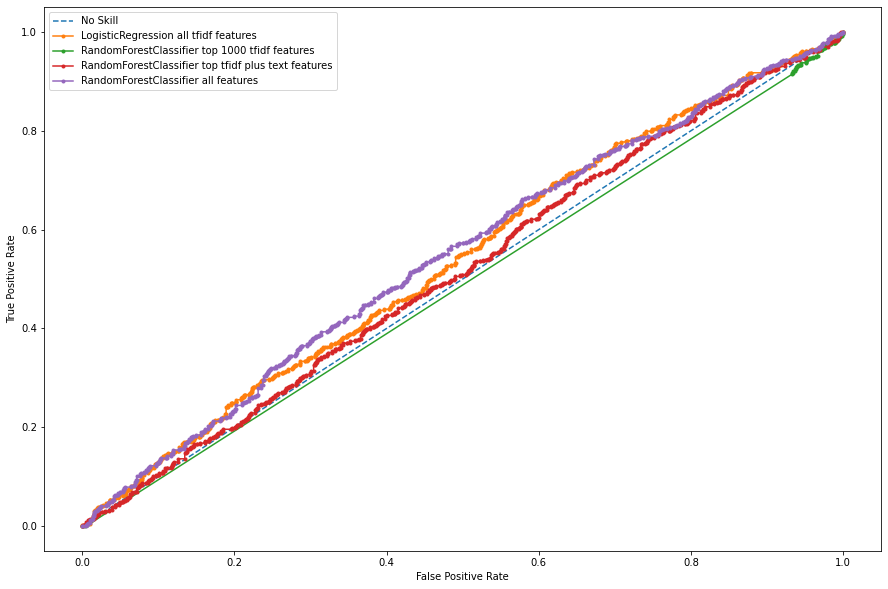

In [745]:
#drawing roc curve and auc


from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

## plot the roc curve: start with no skill prediction
fig, ax = plt.subplots(figsize=(15, 10))
ns_auc = roc_auc_score(y_test, ns_probs) #no skill
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')


#draw roc curves for tuned models
def draw_roc_curve(model, label):
    model_name=type(model[0]).__name__
    # retrieve roc auc scores
    auc = model[1]
    # calculate roc curves
    # get tpr, fpr
    fpr=model[2]
    tpr=model[3]
    print('Model=%s; Data=%s; ROC AUC=%.3f' % (model_name, label, auc)) 
    lab=model_name+" "+label
    plt.plot(fpr, tpr, marker='.', label=lab)

    
model_dict={'all tfidf features':lr_fit_tfidf, 'top 1000 tfidf features': lr_fit_1000, 'top tfidf plus text features': lr_fit_text,'all features': lr_fit_all, 'top 1000 tfidf features': rf_fit_1000, 'top tfidf plus text features': rf_fit_text,'all features': rf_fit_all}


#WHY CAN I NOT DRAW ALL LINES IN ONE GRAPH USING A LOOP?
for k,v in model_dict.items():
    draw_roc_curve(v,k)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
